# <span style="color:blue">Comparison of sklearn classifiers using Wisconsin breast cancer dataset</span>

## Defining functions:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.6f}'.format
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn import metrics, tree
import csv

random_state = 0

def dt(y, X, weights = None, max_depth = None, output = False):
    if isinstance(weights, list):
        clf = tree.DecisionTreeClassifier(random_state = random_state, max_depth = max_depth).fit(X, y, weights)
    else:
        clf = tree.DecisionTreeClassifier(random_state = random_state, max_depth = max_depth).fit(X, y)
    if output:
        classification_metrics(y, X, clf, clf_type = 'dt')
    return clf

def rf(y, X, weights = None, max_depth = None, output = False):
    if isinstance(weights, list):
        clf = RandomForestClassifier(n_estimators = 100, random_state = random_state, max_depth = max_depth).fit(X, y, weights)
    else:
        clf = RandomForestClassifier(n_estimators = 100, random_state = random_state, max_depth = max_depth).fit(X, y)
    if output:
        classification_metrics(y, X, clf, clf_type = 'rf')
    return clf

def gb(y, X, weights = None, max_depth = 3, output = False):
    if isinstance(weights, list):
        clf = GradientBoostingClassifier(random_state = random_state, max_depth = max_depth).fit(X, y, weights)
    else:
        clf = GradientBoostingClassifier(random_state = random_state, max_depth = max_depth).fit(X, y)
    if output:
        classification_metrics(y, X, clf, clf_type = 'gb')
    return clf

def gnb(y, X, weights = None, output = False):
    if isinstance(weights, list):
        clf = GaussianNB().fit(X, y, weights)
    else:
        clf = GaussianNB().fit(X, y)
    if output:
        classification_metrics(y, X, clf, clf_type = 'gnb')
    return clf

def logit(y, X, weights = None, output = False):
    if not isinstance(weights, list):
        clf = sm.GLM(y, X, family = sm.families.Binomial()).fit()
    else:
        clf = sm.GLM(y, X, family = sm.families.Binomial(), freq_weights = weights).fit()
    display(clf.summary())
    if output:
        classification_metrics(y, X, clf)
    return clf

def classification_metrics(y, X, clf, clf_type = 'logit'):
    if clf_type == 'logit':
        p_preds = clf.predict(X)
        y_preds = p_preds.map(lambda x: 0 if x < 0.5 else 1)
    elif clf_type in ['dt', 'rf', 'gb', 'gnb', 'sk-logit']:
        y_preds = clf.predict(X)
        p_preds = clf.predict_proba(X)[:, 1]
        if clf_type == 'dt':
            #tree plot
            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (30,30), dpi = 100)
            tree.plot_tree(clf, feature_names = X.columns.values, filled = True, fontsize = 16, max_depth = 3)
            plt.show()
        if clf_type not in ['gnb','sk-logit']:
            plot_feature_importances(clf, clf_type, X, top_n = 10, figsize = (8,8),
                                     print_table = True, title = 'Top 10 Feature Importances: ')
        if clf_type == 'sk-logit':
            coef = clf.coef_
            var = X.columns.values
            coef = pd.DataFrame([var, coef[0]]).T
            coef.columns = ['Variable', 'Coefficient']
            coef = coef.set_index('Variable')
            display(coef)
    else:
        print('Error: invalid clf_type')
        return
    
    #metrics calculation
    fpr, tpr, thresholds = roc_curve(y, p_preds)
    conf_m = confusion_matrix(y, y_preds)
    plt.show()
    tn, fp, fn, tp = conf_m.ravel()
    conf_m = pd.DataFrame(conf_m)
    conf_m.columns = ['Pred Negative','Pred Positive']
    conf_m.index = ['Actual Negative','Actual Positive']
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    bal_acc = balanced_accuracy_score(y, y_preds)
    auc = np.trapz(tpr, fpr)
    auc2 = metrics.roc_auc_score(y, p_preds)
    ks_diff = tpr - fpr
    ks = max(ks_diff)
    
    #metrics display
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    print('Confusion Matrix: ')
    display(conf_m)
    print()
    
    results = [['AUC', str(auc2)],
              ['KS', str(ks)],
              ['Sensitivity', str(sensitivity)],
              ['Specificity', str(specificity)],
              ['Accuracy', str(accuracy)],
              ['Balanced Accuracy', str(bal_acc)]]
    results = pd.DataFrame(results)
    results.columns = ['Statistic','Value']
    results = results.set_index('Statistic')
    display(results)
    
    
    
def plot_feature_importances(clf, clf_type, X, top_n = 10, figsize = (8,8), print_table = False, title = 'Feature Importances'):
    names = {
        'dt': 'Decision Tree',
        'rf': 'Random Forest',
        'gb': 'Gradient Boosting'
    }
    title = title + names.get(clf_type)
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})
    feat_imp['feature'] = X.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop = True)
    feat_imp.plot.barh(title = title, figsize = figsize, legend = None)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print('Top {} features in descending order of importance'.format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

def compare_stats(y, X, X_lg, clfs, names):
    table = []
    for clf, name in zip(clfs, names):
        if name == 'logit':
            y_preds = clf.predict(X_lg)
            p_preds = clf.predict_proba(X_lg)[:, 1]
        else:
            y_preds = clf.predict(X)
            p_preds = clf.predict_proba(X)[:, 1]
        #metrics calculation
        fpr, tpr, thresholds = roc_curve(y, p_preds)
        conf_m = confusion_matrix(y, y_preds)
        tn, fp, fn, tp = conf_m.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        bal_acc = balanced_accuracy_score(y, y_preds)
        auc = np.trapz(tpr, fpr)
        auc2 = metrics.roc_auc_score(y, p_preds)
        ks_diff = tpr - fpr
        ks = max(ks_diff)
        row = [auc2, ks, sensitivity, specificity, accuracy, bal_acc]
        row = map(lambda x: str(round(x, 6)), row)
        table.append(row)
    table = pd.DataFrame(table)
    table.columns = ['AUC','KS-test','Sensitivity','Specificity','Accuracy','Balanced Accuracy']
    table.index = names
    display(table)
    
def compare_roc(y, X, X_lg, clfs, names):
    fig, ax = plt.subplots(dpi = 200)
    for clf, name in zip(clfs, names):
        if name == 'logit':
            p_preds = clf.predict_proba(X_lg)[:,1]
        else:
            p_preds = clf.predict_proba(X)[:,1]
        fpr, tpr, thresholds = roc_curve(y, p_preds)
        ax.plot(fpr, tpr)
    ax.legend(names)
    ax.set_title('ROC Curve')
    ax.xaxis.set_label_text('False Positive Rate')
    ax.yaxis.set_label_text('True Positive Rate')
    plt.show()

## Loading dataset:

In [2]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data)
X.columns = dataset.feature_names
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.990000,10.380000,122.800000,1001.000000,0.118400,0.277600,0.300100,0.147100,0.241900,0.078710,1.095000,0.905300,8.589000,153.400000,0.006399,0.049040,0.053730,0.015870,0.030030,0.006193,25.380000,17.330000,184.600000,2019.000000,0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
1,20.570000,17.770000,132.900000,1326.000000,0.084740,0.078640,0.086900,0.070170,0.181200,0.056670,0.543500,0.733900,3.398000,74.080000,0.005225,0.013080,0.018600,0.013400,0.013890,0.003532,24.990000,23.410000,158.800000,1956.000000,0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
2,19.690000,21.250000,130.000000,1203.000000,0.109600,0.159900,0.197400,0.127900,0.206900,0.059990,0.745600,0.786900,4.585000,94.030000,0.006150,0.040060,0.038320,0.020580,0.022500,0.004571,23.570000,25.530000,152.500000,1709.000000,0.144400,0.424500,0.450400,0.243000,0.361300,0.087580
3,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,0.097440,0.495600,1.156000,3.445000,27.230000,0.009110,0.074580,0.056610,0.018670,0.059630,0.009208,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000
4,20.290000,14.340000,135.100000,1297.000000,0.100300,0.132800,0.198000,0.104300,0.180900,0.058830,0.757200,0.781300,5.438000,94.440000,0.011490,0.024610,0.056880,0.018850,0.017560,0.005115,22.540000,16.670000,152.200000,1575.000000,0.137400,0.205000,0.400000,0.162500,0.236400,0.076780


In [3]:
y = pd.DataFrame(dataset.target, columns = ['target'])
y = y.values.ravel()

## Decision Tree:

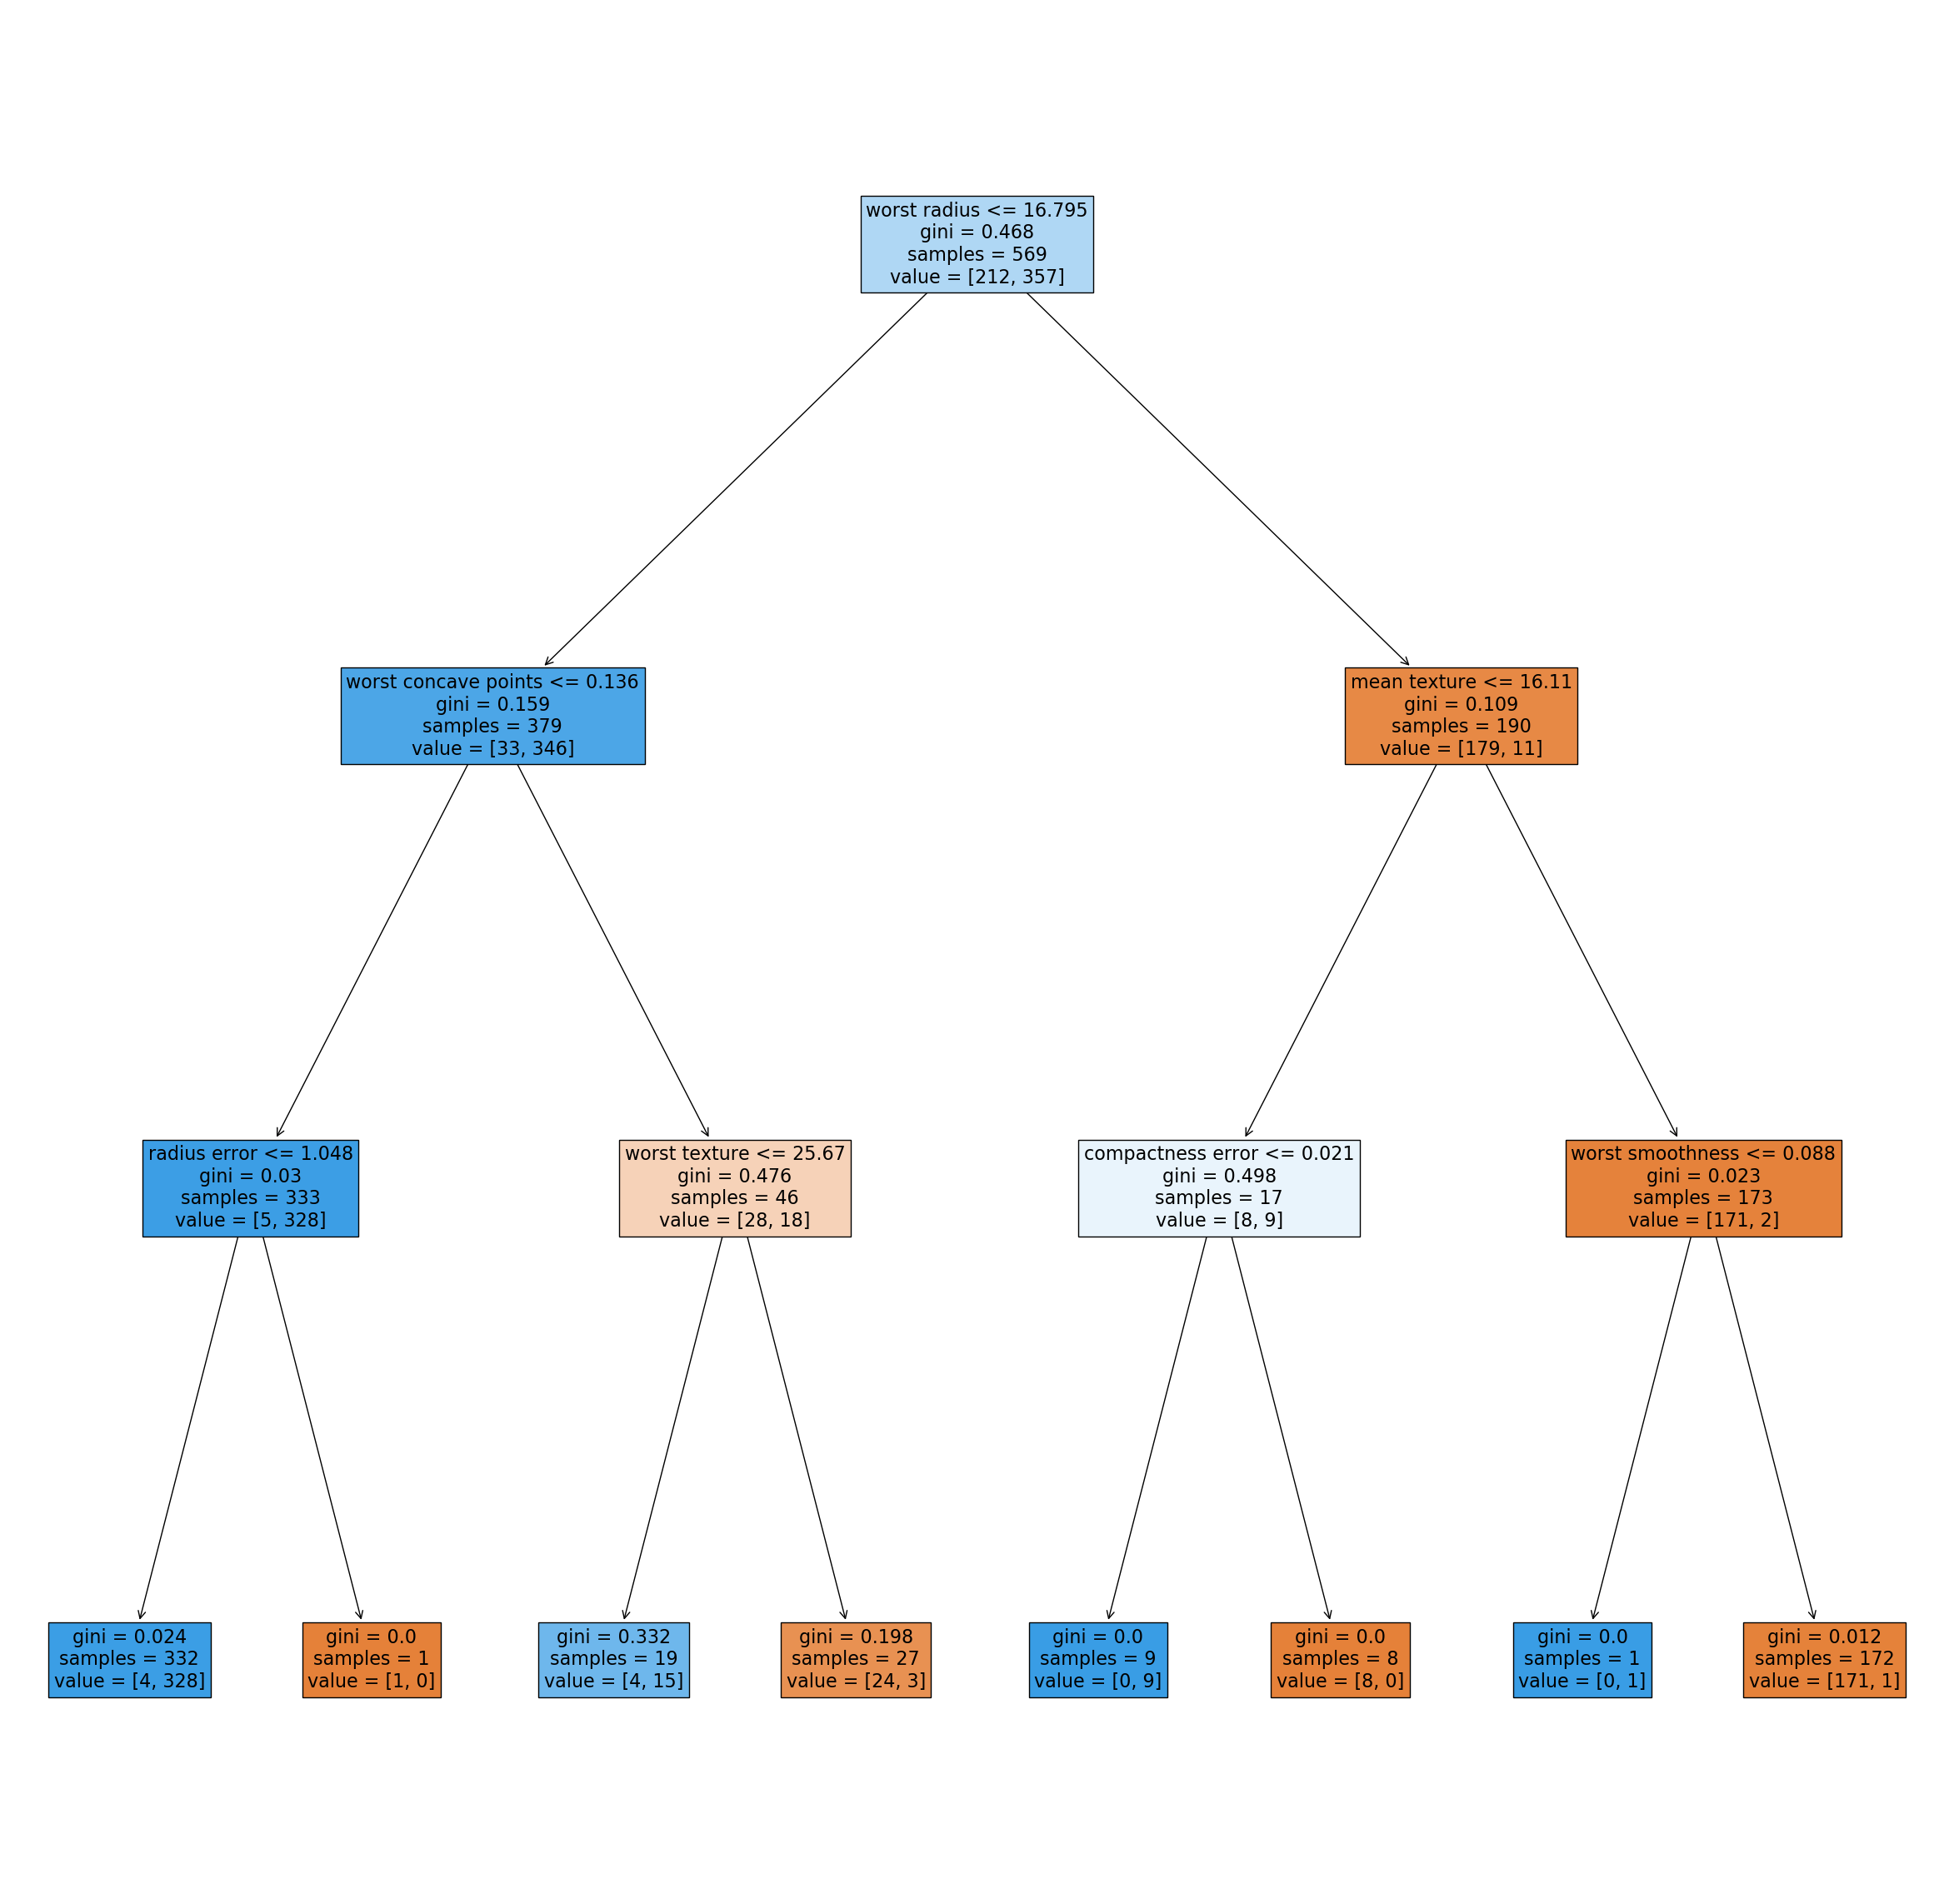

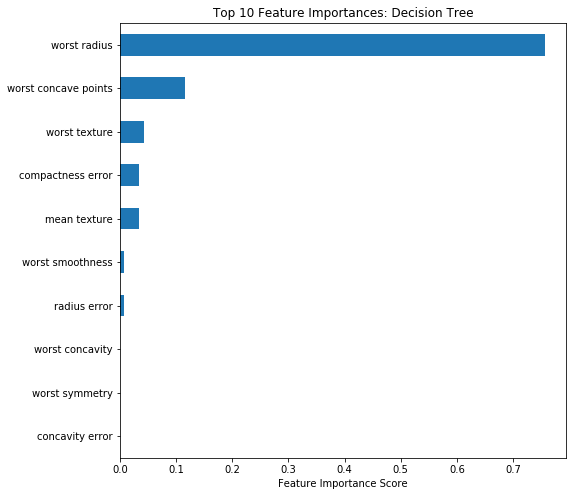

Top 10 features in descending order of importance


,importance
feature,
worst radius,0.756881
worst concave points,0.116533
worst texture,0.041982
compactness error,0.034647
mean texture,0.033957
worst smoothness,0.008039
radius error,0.007961
concavity error,0.000000
worst symmetry,0.000000


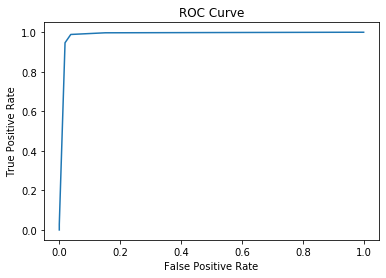

Confusion Matrix: 


,Pred Negative,Pred Positive
Actual Negative,204,8
Actual Positive,4,353


,Value
Statistic,
AUC,0.9877979493684267
KS,0.9510596691506792
Sensitivity,0.988795518207283
Specificity,0.9622641509433962
Accuracy,0.9789103690685413
Balanced Accuracy,0.9755298345753396


In [4]:
clf_dt = dt(y, X, max_depth = 3, output = True)

## Random Forest:

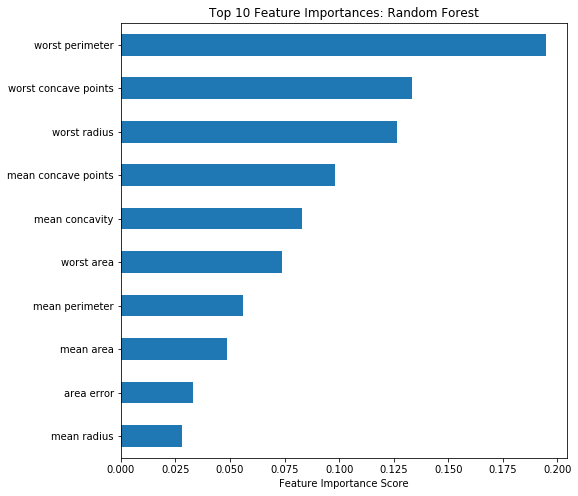

Top 10 features in descending order of importance


,importance
feature,
worst perimeter,0.194797
worst concave points,0.133586
worst radius,0.126501
mean concave points,0.098348
mean concavity,0.082835
worst area,0.073926
mean perimeter,0.055872
mean area,0.048775
area error,0.033198


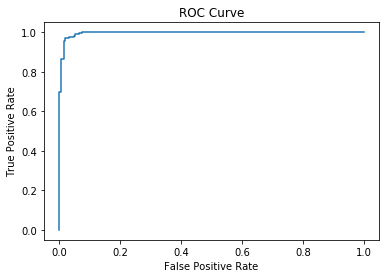

Confusion Matrix: 


,Pred Negative,Pred Positive
Actual Negative,201,11
Actual Positive,4,353


,Value
Statistic,
AUC,0.9960890016383913
KS,0.9503197505417261
Sensitivity,0.988795518207283
Specificity,0.9481132075471698
Accuracy,0.9736379613356766
Balanced Accuracy,0.9684543628772264


In [5]:
clf_rf = rf(y, X, max_depth = 3, output=True)

## Gradient Boosting:

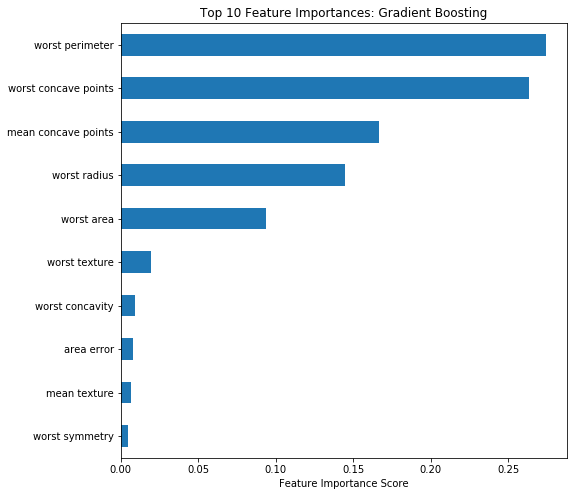

Top 10 features in descending order of importance


,importance
feature,
worst perimeter,0.274503
worst concave points,0.263806
mean concave points,0.166664
worst radius,0.144587
worst area,0.093699
worst texture,0.019553
worst concavity,0.009144
area error,0.007889
mean texture,0.006668


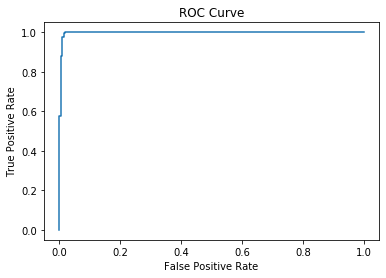

Confusion Matrix: 


,Pred Negative,Pred Positive
Actual Negative,208,4
Actual Positive,1,356


,Value
Statistic,
AUC,0.9973045822102427
KS,0.9811320754716981
Sensitivity,0.9971988795518207
Specificity,0.9811320754716981
Accuracy,0.9912126537785588
Balanced Accuracy,0.9891654775117594


In [6]:
clf_gb = gb(y, X, max_depth = 1, output=True)

## Gaussian Naive Bayes:

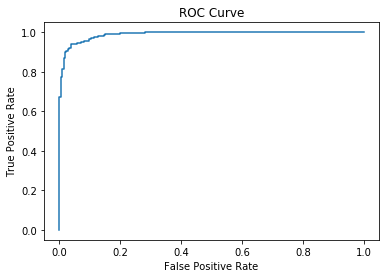

Confusion Matrix: 


,Pred Negative,Pred Positive
Actual Negative,189,23
Actual Positive,10,347


,Value
Statistic,
AUC,0.9890333491887321
KS,0.9006395010834523
Sensitivity,0.9719887955182073
Specificity,0.8915094339622641
Accuracy,0.9420035149384886
Balanced Accuracy,0.9317491147402357


In [7]:
clf_gnb = gnb(y, X, output=True)

## ROC Curve Comparison of Models:

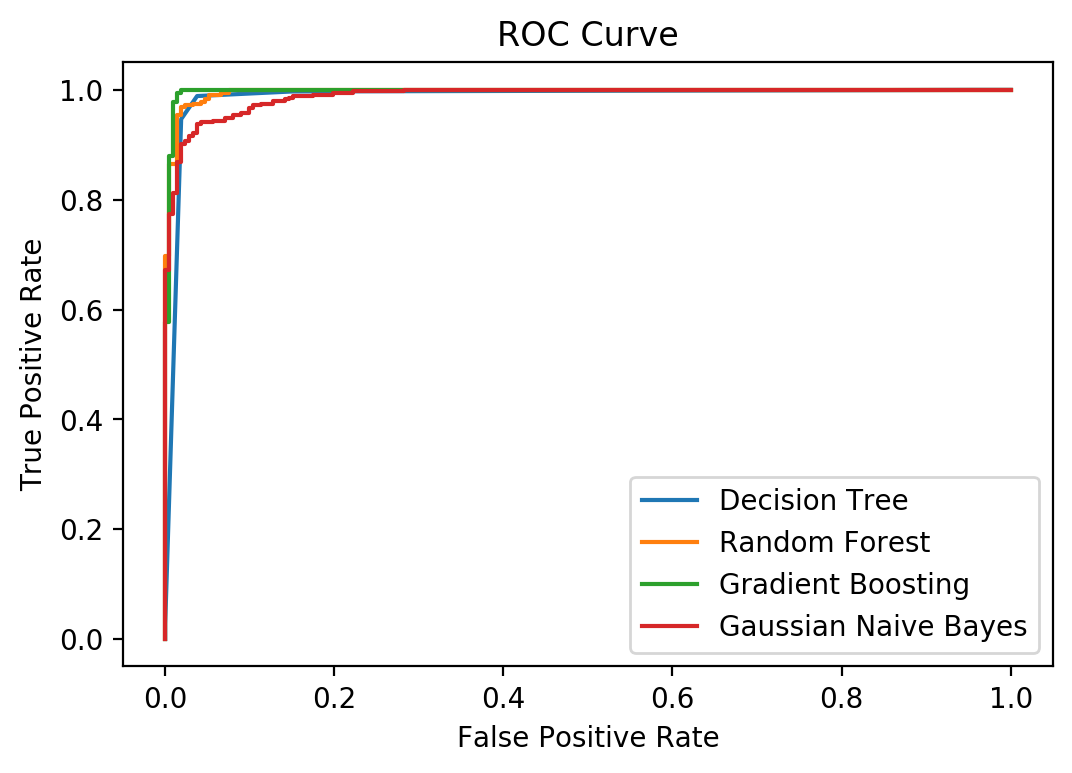

In [8]:
clfs = [clf_dt, clf_rf, clf_gb, clf_gnb]
names = ['Decision Tree','Random Forest', 'Gradient Boosting', 'Gaussian Naive Bayes']

compare_roc(y, X, None, clfs, names)

## Table comparing statistics from each model:

In [9]:
compare_stats(y, X, None, clfs, names)

,AUC,KS-test,Sensitivity,Specificity,Accuracy,Balanced Accuracy
Decision Tree,0.987798,0.95106,0.988796,0.962264,0.97891,0.97553
Random Forest,0.996089,0.95032,0.988796,0.948113,0.973638,0.968454
Gradient Boosting,0.997305,0.981132,0.997199,0.981132,0.991213,0.989165
Gaussian Naive Bayes,0.989033,0.90064,0.971989,0.891509,0.942004,0.931749


## Voting Classifier Comparison:

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
eclf = VotingClassifier(estimators = [('dt', clf_dt),
                                     ('rf', clf_rf),
                                     ('gb', clf_gb),
                                     ('gnb', clf_gnb)], voting='hard')
for clf, label in zip(clfs + [eclf], names + ['Ensemble']):
    scores = cross_val_score(clf, X, y, scoring = 'accuracy', cv=5)
    print('Accuracy: %0.6f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.917491 (+/- 0.02) [Decision Tree]
Accuracy: 0.950935 (+/- 0.02) [Random Forest]
Accuracy: 0.963232 (+/- 0.02) [Gradient Boosting]
Accuracy: 0.940377 (+/- 0.02) [Gaussian Naive Bayes]
Accuracy: 0.949227 (+/- 0.03) [Ensemble]
